In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
directory = 'img_align_celeba'

# Get all images from dir
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=directory, color_mode='rgb',
                                                   batch_size=128, image_size=(32,32), label_mode=None,
                                                   shuffle=True, seed=42)

# Normalize the data

dataset=dataset.map(lambda x: x /255.00)

Found 202599 files belonging to 1 classes.


In [4]:
# Grid of image
from mpl_toolkits.axes_grid1 import ImageGrid

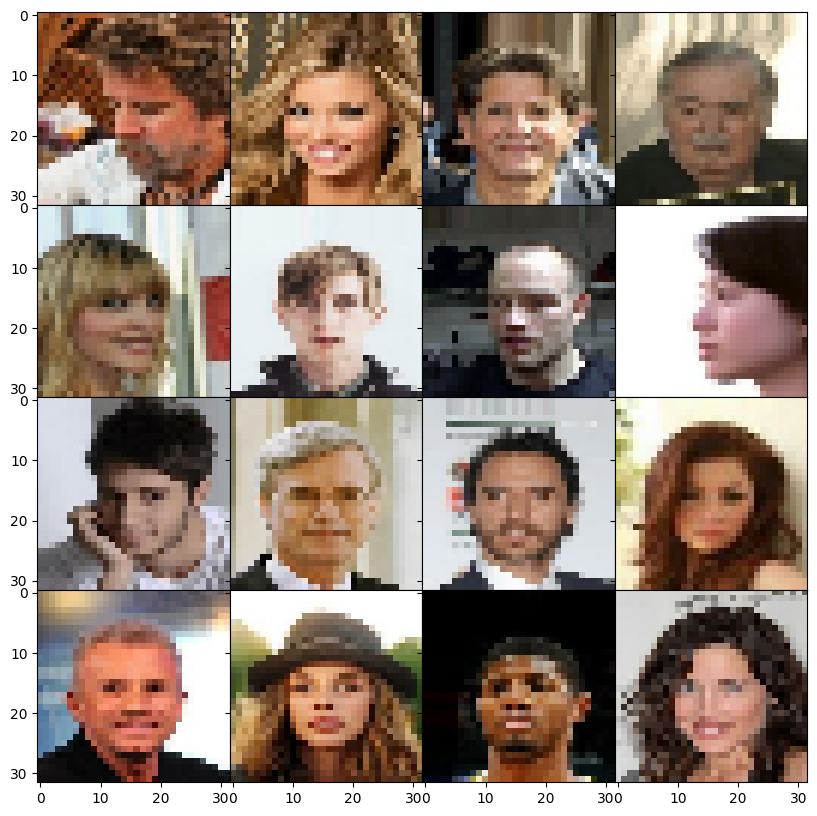

In [5]:
it=iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16,:,:,:]

# show the image

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), 
         axes_pad=0)
for ax,im in zip(grid, images):
    ax.imshow(im)
plt.show()

GANs-> Generartive Adversarial Network
Generator, Disc.
Disc.-> Image Classification Task
Latent-> Noise

In [6]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape
from tensorflow.keras import Model, Input

def discriminator_model():
    disc_input = Input(shape=(32,32,3), name='discriminator_network')
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(disc_input)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Flatten()(x)
    x=Dense(1)(x)
    
    output = Activation('sigmoid')(x)
    
    disc=Model(inputs = disc_input, outputs=output)
    
    return disc

In [7]:
disc_model = discriminator_model()
disc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_network (Inp  [(None, 32, 32, 3)]       0         
 utLayer)                                                        
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                             

In [8]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input
def generator_model(z_dim=100):
    gen_input = Input(shape=(z_dim), name='generator_network')
    
    x = Dense(8*8*3)(gen_input)
    x = Reshape(target_shape=(8,8,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=512, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
        
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1), padding='same')(x)
    fake_images_gen = LeakyReLU()(x)
    
    model_gen=Model(inputs = gen_input, outputs=fake_images_gen)
    
    return model_gen

In [9]:
gen_model = generator_model()

In [10]:
gen_model.summary(0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_network (InputLa  [(None, 100)]             0         
 yer)                                                            
                                                                 
 dense_1 (Dense)             (None, 192)               19392     
                                                                 
 reshape (Reshape)           (None, 8, 8, 3)           0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 3)           12        
 Normalization)                                                  
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 3)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         1433

In [11]:
disc_model = discriminator_model()
gen_model = generator_model()
# Image Classification CNN
# Compile the model that trains disc.
disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
# Compile the model that trains generator
z_dim = 100
disc_model.trainable = False
model_input = Input(shape=(z_dim), name='model_input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 100)]             0         
                                                                 
 model_3 (Functional)        (None, 32, 32, 3)         1736143   
                                                                 
 model_2 (Functional)        (None, 1)                 297281    
                                                                 
Total params: 2033424 (7.76 MB)
Trainable params: 1733961 (6.61 MB)
Non-trainable params: 299463 (1.14 MB)
_________________________________________________________________


In [14]:
def train_discriminator(batch, batch_size):
    valid = np.ones((batch_size, 1)) 
    fake = np.zeros((batch_size, 1)) 
    
    disc_model.train_on_batch(batch, valid)
    
    noise = np.random.normal(0,1, (batch_size, z_dim))
    gen_image = gen_model.predict(noise)
    disc_model.train_on_batch(gen_image, fake)
def train_generator(batch_size):
    valid = np.ones((batch_size, 1)) 
    noise = np.random.normal(0,1, (batch_size, z_dim))
    model.train_on_batch(noise, valid)

In [15]:
def save_image(fake_image, path):
    image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path, image)
    return image
def generate_and_save_image(path):
    noise = np.random.normal(0,1, (1, z_dim))
    fake_images = gen_model(noise)
    image = save_image(fake_images[0], path)
    plt.imshow(image)
    plt.show()

In [17]:
# Function to generate and save images
def generate_and_save_image(gen_model, z_dim, path):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Generate fake image
    noise = np.random.normal(0, 1, (1, z_dim))  # Random noise for generator
    fake_images = gen_model(noise)  # Generate fake image
    image = save_image(fake_images[0], path)  # Save generated image
    plt.imshow(image)  # Display the image
    plt.show()

No of Epochs-> 0
4/4 [==============================] - 1s 154ms/step
Batch Images-> 0


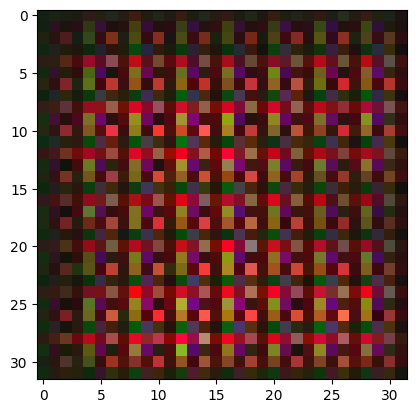

3/4 [=====================>........] - ETA: 0s

KeyboardInterrupt: 

In [18]:
# Training loop
for epochs in range(10):
    print(f'No of Epochs-> {epochs}')
    for i, batch in enumerate(dataset):
        train_discriminator(batch, batch.shape[0])  # Train discriminator
        train_generator(batch.shape[0])  # Train generator
        
        if i % 100 == 0:
            print(f'Batch Images-> {i}')
            # Correct the path string with a raw string or escape single quotes
            PATH = r"C:\Users\vikas\100-Project-Data-science\4 Generate Human Face Using GAN's\generate_face"
            generate_and_save_image(
                gen_model=gen_model, 
                z_dim=100, 
                path=f"{PATH}/epochs_{epochs}batch_{i}.jpg"
            )

In [19]:
print("The End")

The End
